In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common import results_plotter
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

import sys
# direc = os.path.dirname(__file__)
# pri&
# caution: path[0] is reserved for script path (or '' in REPL)
# print(str(path)+'/ppo')
sys.path.insert(1, '/Users/faridounet/PhD/TransportersDilemma')
from a_star import A_Star
from SA_baseline import recuit
from greedy_baseline import baseline
from assignment import RemoveActionEnv, AssignmentEnv, GameEnv
import pickle
from shortcut import multi_types
import numpy as np
import matplotlib.pyplot as plt
import collections

from shortcut import multi_types
from GameLearning import LRI, GameLearning, EXP3
from SA_baseline import recuit
from a_star import A_Star
from greedy_baseline import baseline, greedy

np.random.seed(42)

pygame 2.5.2 (SDL 2.28.3, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [18]:
def DP(env : RemoveActionEnv, excess, log = False):
    
    rtes = np.array([
        [
            env._env.initial_routes[m, i] 
            for i in range(0, len(env._env.initial_routes[m]), 2)
        ]
        for m in range(len(env._env.initial_routes))
    ], dtype=int)


    # print(env._env.distance_matrix)
    # print(CM)
    coeff = env._env._game.emissions_KM
    # CM = np.array([
    #     env._env.distance_matrix*coeff[i]
    #     for i in range(len(coeff))
    # ]).copy()
    a = multi_types(env._env.distance_matrix, rtes, coeff, excess)


    _, r, *_ = env.step(a)
    
    if log:
        print(env.destinations)
        print(env._env.distance_matrix)
    
    return a, r

def SA(env, log = False):
    
    if log:
        print(env.destinations)
        print(env._env.distance_matrix)
    T_init = 5_000
    T_limit = 1
    lamb = 0.9999
    T = 100_000

    action_SA, *_ = recuit(deepcopy(env._env), T_init, T_limit, lamb, H=T)
            # res = recuit_multiple(game, T_init = T_init, T_limit = T_limit, lamb = lamb, log=log, H=T)
    a = np.where(action_SA == 0)[0]

    # CM = np.array([
    #     env._env.distance_matrix*coeff[i]
    #     for i in range(len(coeff))
    # ]).copy()

    # env = RemoveActionEnv(game = g, saved_routes = routes, saved_dests=dests, 
    #                       obs_mode='elimination_gain', 
    #                       action_mode = 'destinations',
    #                         change_instance = True, rewards_mode='normalized_terminal', instance_id = 89)

    _, r, *_, info = env.step(a)
    
    if log:
        print(env.destinations)
        print(env._env.distance_matrix)
    
    return a, r

In [3]:
K = 16
with open(f'RL/game_K{K}.pkl', 'rb') as f:
    g = pickle.load(f)
routes = np.load(f'RL/routes_K{K}.npy')
dests = np.load(f'RL/destinations_K{K}.npy')

with open(f'res_compare_EG_A*_SA_K{K}_n100.pkl', 'rb') as f:
    data = pickle.load(f)
    
if K == 100:
    g.Q = 40

In [4]:
# On recalcule les rewards
rewards = []
for k in data.keys():
    rs = np.zeros(len(data[k]))
    for i in data[k].keys():
        sol = data[k][i]['sol']
        env = RemoveActionEnv(game = g, saved_routes = routes, saved_dests=dests, 
                      obs_mode='elimination_gain', 
                      action_mode = 'destinations',
                        change_instance = True, rewards_mode='normalized_terminal', instance_id = int(i))
        env.reset()
        _, r, *_ = env.step(sol)
        if r == 0:
            print(k)
            print(i)
            print(sol)
        rs[i] = r
    rewards.append(rs)

res_A
9
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
res_A
14
[ 2  3  4  6  7  8 12 13 14 15]
res_A
26
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
res_A
28
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
res_A
32
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
res_A
42
[ 0  3  4  5  6  7  8 11 13 14 15]
res_A
43
[ 0  1  5  6  8  9 12 13 14 15]
res_A
62
[ 0  1  2  3  4  5  6  7 13 14 15]
res_A
68
[ 2  3  5  6  7  9 11 12 13 14 15]
res_A
70
[ 0  3  5  8  9 10 11 12 13 14 15]
res_A
77
[ 0  3  4  6  7  8 11 12 13 14 15]
res_A
90
[ 5  6  9 10 11 15]
res_A
93
[ 0  1  2  3  6  7  8  9 10 11 12 13]
res_A
98
[ 0  1  2  3  6  7  8 12 15]
res_greedy
9
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
res_greedy
26
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
res_greedy
28
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
res_greedy
32
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
res_greedy
68
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
res_greedy
90
[ 0  1  2  3  4 

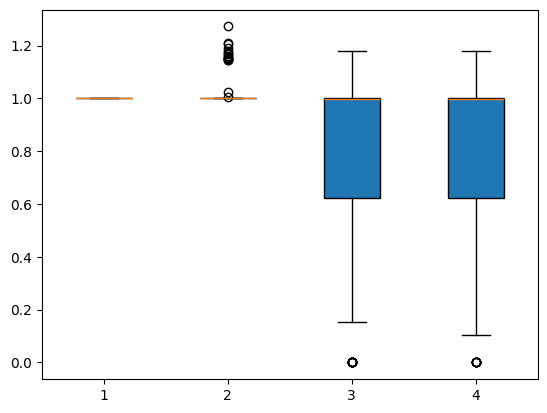

In [5]:
# affichage
rr = []
for rs in rewards:
    rr.append(rs/(rewards[0]))
    
plt.boxplot(
        rr,
        patch_artist=True,
        )
plt.show()

In [6]:
# On regarde ou la DP sous-performe
print(np.where(rr[1]>1))
print(np.where(rr[2]>1))
print(np.where(rr[3]>1))

(array([ 3, 12, 20, 25, 29, 30, 31, 44, 46, 47, 50, 63, 66, 79, 81, 98]),)
(array([12, 25, 30, 63, 66, 81]),)
(array([12, 25, 30, 63, 66, 81]),)


In [7]:
# On cible une instance
instance = 12

In [8]:
# On reessaye la DP
env = RemoveActionEnv(game = g, saved_routes = routes, saved_dests=dests, 
                      obs_mode='elimination_gain', 
                      action_mode = 'destinations',
                        change_instance = False, rewards_mode='normalized_terminal', instance_id = instance)
_, info = env.reset()
excess = info['excess_emission']

rtes = np.array([
    [
        env._env.initial_routes[m, i] 
        for i in range(0, len(env._env.initial_routes[m]), 2)
    ]
    for m in range(len(env._env.initial_routes))
], dtype=int)


# print(env._env.distance_matrix)
# print(CM)
coeff = env._env._game.emissions_KM
# CM = np.array([
#     env._env.distance_matrix*coeff[i]
#     for i in range(len(coeff))
# ]).copy()
a = multi_types(env._env.distance_matrix, rtes, coeff, excess)


_, r, *_ = env.step(a)
print('la solution calculee à nouveau : ', a +1)
print('reward obtenue par la solution calculee à nouveau : ', r)

print('la solution calculee dans la sim : ', data['res_DP'][instance]['sol'] + 1)
print('reward obtenue par la solution calculee dans la sim : ', rewards[0][instance])


max ommited: [8 8]
solution de taille 9 [1 8] valeur 68.0
la solution calculee à nouveau :  [ 3  8  2  1  5  6 10 16 15]
reward obtenue par la solution calculee à nouveau :  0.396455223880597
la solution calculee dans la sim :  [ 3  8  2  1  5  6 10 16 15]
reward obtenue par la solution calculee dans la sim :  0.396455223880597


In [9]:
print(rtes)

[[ 0 13  7  4  3  9 11 14 12  0]
 [ 0  8  2  1  5  6 10 16 15  0]]


In [10]:
env = RemoveActionEnv(game = g, saved_routes = routes, saved_dests=dests, 
                    obs_mode='elimination_gain', 
                    action_mode = 'destinations',
                    change_instance = False, rewards_mode='normalized_terminal', instance_id = instance
)
_, info = env.reset()
excess = info['excess_emission']
T_init = 5_000
T_limit = 1
lamb = 0.9999
T = 100_000

action_SA, *_ = recuit(deepcopy(env._env), T_init, T_limit, lamb, H=T)
        # res = recuit_multiple(game, T_init = T_init, T_limit = T_limit, lamb = lamb, log=log, H=T)
a = np.where(action_SA == 0)[0]

# CM = np.array([
#     env._env.distance_matrix*coeff[i]
#     for i in range(len(coeff))
# ]).copy()

# env = RemoveActionEnv(game = g, saved_routes = routes, saved_dests=dests, 
#                       obs_mode='elimination_gain', 
#                       action_mode = 'destinations',
#                         change_instance = True, rewards_mode='normalized_terminal', instance_id = 89)

env.reset()
_, r, *_, info = env.step(a)
print('la solution calculee à nouveau : ', a + 1)
print('reward obtenue par la solution calculee à nouveau : ', r)

print('la solution calculee dans la sim : ', data['res_SA'][instance]['sol'] +1)
print('reward obtenue par la solution calculee dans la sim : ', rewards[1][instance])

la solution calculee à nouveau :  [ 1  2  5  6  8 10 15 16]
reward obtenue par la solution calculee à nouveau :  0.4533582089552239
la solution calculee dans la sim :  [ 1  2  5  6  8 10 15 16]
reward obtenue par la solution calculee dans la sim :  0.4533582089552239


In [11]:
from assignment import AssignmentGame


g = AssignmentGame(
            grid_size=12,
            max_capacity=1,
            Q = 7,
            K=2,
            emissions_KM = [.1, .3],
            costs_KM = [1, 1],
            seed=42
        )
env = RemoveActionEnv(game = g)
env.reset()

(array([0.0000e+00, 9.0090e+03, 2.0000e+00, 9.0090e+03, 0.0000e+00,
        0.0000e+00, 5.1017e+04, 1.0000e+00, 5.1017e+04, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 5.0000e+00, 1.0000e+00, 1.0000e+00]),
 {'solution_found': True,
  'costs': 52.0,
  'time_per_vehicle': array([0.45, 0.85]),
  'distance_per_vehicle': array([18., 34.]),
  'excess_emission': 5.0,
  'omitted': 0,
  'solution': [[0, 2, 0], [0, 1, 0]]})

In [20]:
for i in range(20):
    *_, info = env.reset()
    aDP, rDP = DP(deepcopy(env), info['excess_emission'])
    aSA, rSA = SA(deepcopy(env))
    if rSA>rDP:
        print(50*'+')
        print(i)
        print('instance info :')
        print(info)
        print(10*'-')
        print('la solution DP : ', aDP +1)
        print('reward DP : ', rDP)

        print('la solution SA : ', aSA +1)
        print('reward SA : ', rSA)
        
        print(50*'+')

max ommited: [1 1]
solution de taille 1 [0 1] valeur 14.0
++++++++++++++++++++++++++++++++++++++++++++++++++
0
instance info :
{'solution_found': True, 'costs': 52.0, 'time_per_vehicle': array([0.85, 0.45]), 'distance_per_vehicle': array([34., 18.]), 'excess_emission': 1.8000000000000007, 'omitted': 0, 'solution': [[0, 1, 0], [0, 2, 0]]}
----------
la solution DP :  [2]
reward DP :  0.2246376811594203
la solution SA :  [1]
reward SA :  0.39855072463768115
++++++++++++++++++++++++++++++++++++++++++++++++++
max ommited: [1 1]
solution de taille 1 [0 1] valeur 24.0
max ommited: [1 1]
solution de taille 1 [0 1] valeur 24.0
max ommited: [1 1]
solution de taille 1 [0 1] valeur 36.0
max ommited: [1 1]
solution de taille 1 [0 1] valeur 14.0
++++++++++++++++++++++++++++++++++++++++++++++++++
4
instance info :
{'solution_found': True, 'costs': 52.0, 'time_per_vehicle': array([0.85, 0.45]), 'distance_per_vehicle': array([34., 18.]), 'excess_emission': 1.8000000000000007, 'omitted': 0, 'solution':